# 沪深300股回测分析

通过tushare Pro取沪深300成份股最近一个月的行情数据，使用RNN算法根据每股收益和市值排序做分组收益率回测。

#### 导入需要的库

In [1]:
import tushare as ts
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

####  设置我的token，获取从20230301-20230331的所有数据

In [2]:
pro = ts.pro_api(token='2cb7b30105056801542e9ff02a8370c509b84397686c94376801c170')
hs300 = pro.index_weight(index_code='000300.SH', start_date='20230301', end_date='20230331')

In [3]:
df = pd.DataFrame()
for ts_code in hs300.con_code.tolist():
    data = pro.daily(ts_code=ts_code, start_date='20230301', end_date='20230331')
    df = pd.concat([df, data], ignore_index=True)

df['trade_date'] = pd.to_datetime(df['trade_date'], format='%Y%m%d')
df = df.sort_values(by='trade_date', ascending=True)

df_basic = pro.daily_basic(ts_code=','.join(hs300.con_code.tolist()), trade_date='20230331',
                            fields='ts_code,trade_date,pe,pb,total_mv')

df_basic['trade_date'] = pd.to_datetime(df_basic['trade_date'])
df_merged = pd.merge(df, df_basic, on=['ts_code', 'trade_date'], how='left')
df_merged = df_merged.dropna(subset=['pe', 'pb', 'total_mv'])
df_merged['eps'] = df_merged['close'] / df_merged['pe']
df_merged['circ_mv'] = df_merged['total_mv'] / df_merged['pb']
df_merged = df_merged.sort_values(by=['eps', 'circ_mv'], ascending=False)
print(df_merged)

         ts_code trade_date     open     high      low    close  pre_close  \
13432  600519.SH 2023-03-31  1825.00  1848.00  1819.00  1820.00    1800.00   
13620  600519.SH 2023-03-31  1825.00  1848.00  1819.00  1820.00    1800.00   
13270  002756.SZ 2023-03-31    83.99    85.17    83.79    83.90      83.71   
13754  002756.SZ 2023-03-31    83.99    85.17    83.79    83.90      83.71   
13391  688169.SH 2023-03-31   370.00   379.99   364.00   365.00     371.48   
...          ...        ...      ...      ...      ...      ...        ...   
13539  000100.SZ 2023-03-31     4.44     4.45     4.36     4.43       4.46   
13372  601989.SH 2023-03-31     3.75     3.78     3.74     3.78       3.77   
13747  601989.SH 2023-03-31     3.75     3.78     3.74     3.78       3.77   
13695  601236.SH 2023-03-31     8.61     8.67     8.50     8.63       8.82   
13732  601236.SH 2023-03-31     8.61     8.67     8.50     8.63       8.82   

       change  pct_chg         vol       amount         pe     

#### 设置分组大小，并进行分组

In [4]:
group_num = 10
group_size = len(df_merged) // group_num

#### 将时间序列数据转换为输入特征

In [5]:
def time_series_to_features(df, time_steps):
    features = []
    for i in range(time_steps, len(df)):
        features.append(df[i-time_steps:i, 0])
    return np.array(features)
X = df_merged[['eps', 'circ_mv']].values
scaler = StandardScaler()
X = scaler.fit_transform(X[:, [0]])
time_steps = 30
X_ts = time_series_to_features(X, time_steps)
y_ts = df_merged['pct_chg'].values[time_steps:]

#### 划分训练集和测试集

In [6]:
train_size = int(len(X_ts) * 0.8)
X_train, X_test = X_ts[:train_size], X_ts[train_size:]
y_train, y_test = y_ts[:train_size], y_ts[train_size:]

#### 建立 RNN 模型

In [7]:
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_ts.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

#### 将输入数据reshape成LSTM模型需要的形状

In [8]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

#### 训练模型，迭代50次

In [9]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
14/14 [==============================] - 5s 92ms/step - loss: 7.0602 - val_loss: 4.7175
Epoch 2/50
14/14 [==============================] - 0s 25ms/step - loss: 6.9787 - val_loss: 4.4645
Epoch 3/50
14/14 [==============================] - 0s 24ms/step - loss: 7.0295 - val_loss: 4.4330
Epoch 4/50
14/14 [==============================] - 0s 23ms/step - loss: 6.9848 - val_loss: 4.6607
Epoch 5/50
14/14 [==============================] - 0s 24ms/step - loss: 7.0021 - val_loss: 4.6414
Epoch 6/50
14/14 [==============================] - 0s 26ms/step - loss: 6.9978 - val_loss: 4.5422
Epoch 7/50
14/14 [==============================] - 0s 24ms/step - loss: 6.9813 - val_loss: 4.4928
Epoch 8/50
14/14 [==============================] - 0s 23ms/step - loss: 6.9935 - val_loss: 4.4456
Epoch 9/50
14/14 [==============================] - 0s 24ms/step - loss: 6.9772 - val_loss: 4.5454
Epoch 10/50
14/14 [==============================] - 0s 24ms/step - loss: 6.9664 - val_loss: 4.4430
Epoch 11/

#### 可视化训练集和验证集上的损失变化

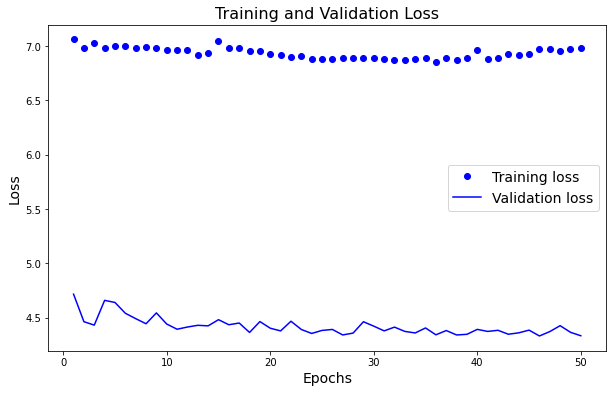

In [10]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

fig, ax = plt.subplots(figsize=(10,6))

ax.plot(epochs, loss, 'bo', label='Training loss')
ax.plot(epochs, val_loss, 'b', label='Validation loss')
ax.set_title('Training and Validation Loss', fontsize=16)
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.legend(fontsize=14)
plt.show()

#### 预测测试集数据

In [11]:
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred).ravel()
print('预测结果y_pre=',sep=' ',end=' ')
print(y_pred)

预测结果y_pre= [4.0711465 4.0779867 4.084519  4.090777  4.0968328 4.1027703 4.108698
 4.114795  4.1211824 4.1279135 4.135009  4.142371  4.149884  4.157432
 4.165022  4.1725755 4.180029  4.1872044 4.1941776 4.2011185 4.208091
 4.2150555 4.221998  4.228931  4.2358313 4.2428107 4.2498875 4.2570815
 4.264357  4.2718477 4.2795753 4.2876387 4.2961106 4.3048925 4.3138776
 4.3229795 4.3321652 4.3412976 4.3503823 4.3594327 4.3684707 4.378201
 4.3889046 4.400645  4.413359  4.4270906 4.441725  4.4572096 4.4733706
 4.4899178 4.506709  4.523483  4.539993  4.5561714 4.5719633 4.5873613
 4.602406  4.6171536 4.6316137 4.6458054 4.6598144 4.673525  4.686949
 4.7001843 4.713225  4.7260485 4.7386556 4.751217  4.7637987 4.776452
 4.789244  4.8018804 4.814666  4.827969  4.841929  4.856396  4.871357
 4.886615  4.902076  4.9175887 4.933001  4.9484553 4.9639473 4.9798546
 4.9964137 5.0136647 5.031618  5.0502653 5.0695724 5.0894747 5.109909
 5.1308455 5.152147  5.1738496 5.195982  5.218333  5.2407    5.262802
 5.2

#### 计算R方值

In [12]:
y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()
r2 = r2_score(y_test, y_pred)
print('R方值:', r2)

R方值: 0.008809590316457894


#### 计算每组收益率

In [13]:
df_merged['y_pred'] = np.nan
df_merged.iloc[-len(y_pred):, df_merged.columns.get_loc('y_pred')] = y_pred.reshape(1, -1)[0]
df_merged['group'] = pd.qcut(df_merged['eps']*df_merged['circ_mv'], group_num, labels=False)
grouped = df_merged.groupby('group')
group_ret = grouped['pct_chg'].mean()

#### 可视化回测结果

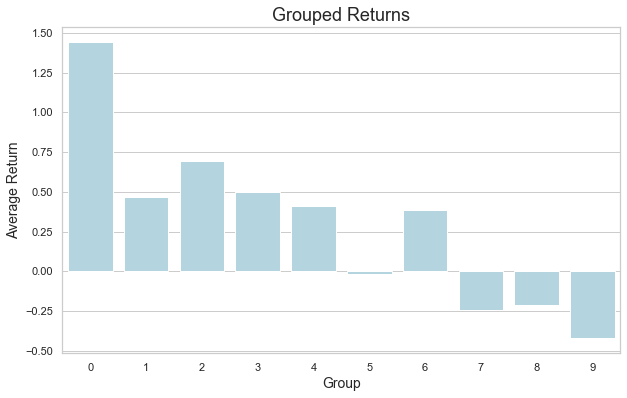

In [14]:
import seaborn as sns

sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(x=group_ret.index, y=group_ret.values, ax=ax, color="lightblue")

ax.set_title("Grouped Returns", fontsize=18)
ax.set_xlabel("Group", fontsize=14)
ax.set_ylabel("Average Return", fontsize=14)

plt.show()

#### 可视化模型预测结果的分布

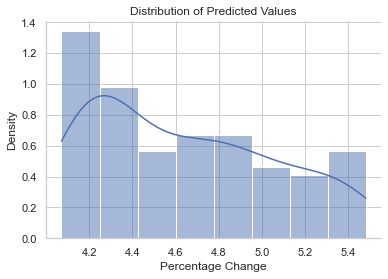

In [15]:
sns.set_style('whitegrid')
sns.histplot(y_pred, kde=True, stat='density')
plt.title('Distribution of Predicted Values')
plt.xlabel('Percentage Change')
sns.despine()
plt.show()

#### 可视化预测结果和真实值的对比

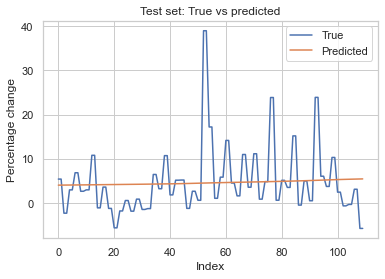

In [16]:
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.title('Test set: True vs predicted')
plt.xlabel('Index')
plt.ylabel('Percentage change')
plt.legend()
plt.show()

#### 可视化预测结果与输入特征之间的关系

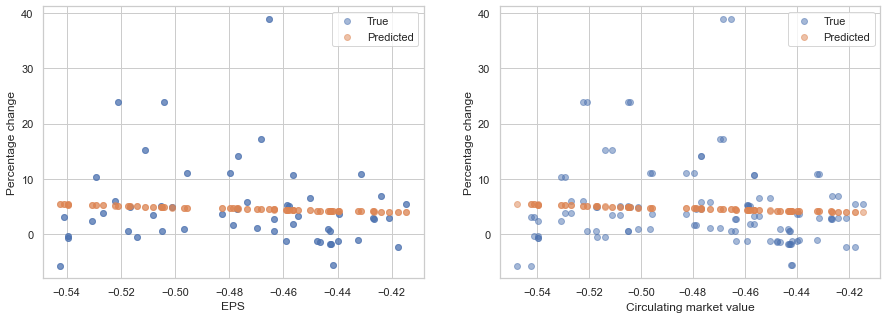

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].scatter(X_test[:, 0], y_test, alpha=0.5)
axs[0].scatter(X_test[:, 0], y_pred, alpha=0.5)
axs[0].set_xlabel('EPS')
axs[0].set_ylabel('Percentage change')
axs[0].legend(['True', 'Predicted'])
axs[1].scatter(X_test[:, 1], y_test, alpha=0.5)
axs[1].scatter(X_test[:, 1], y_pred, alpha=0.5)
axs[1].set_xlabel('Circulating market value')
axs[1].set_ylabel('Percentage change')
axs[1].legend(['True', 'Predicted'])
plt.show()


#### 自我评价
整个模型跑下来的效果一般般，参数例如学习率、批次大小、神经元数等是手动设定的，可以使用网格搜索或贝叶斯优化来自动化寻找最优的超参数组合，以进一步提高模型性能。